## This notebook demonstrates how to run the [GARPOS](https://github.com/s-watanabe-jhod/garpos) software in the EarthScope GeoLab cloud environment.  
04-29-2025

### GeoLab Basics

GeoLab is the name of EarthScope's Jupyter Hub, which allows users to run code via Jupyter notebooks (or in a terminal) on EarthScope resources in AWS.  

The `sfg-geolab` image comes pre-loaded with the software needed to process GNSS-A data. Each user has their own home directory `/home/jovyan` that is mounted to 
the image and any files kept there are accessibile only to that user and remain during future sessions.  

### Data 
For the purposes of this GARPOS demo, we have pre-processed some `cascadia-gorda` data and stored the shot data in an S3 bucket accessible to all users of the GeoLab hub.

Raw data is available via authenticated https from [https://data.earthscope.org/archive/seafloor](https://data.earthscope.org/archive/seafloor).  Where pre-processed data is not available, or you want to create your own, you would use the `data_preprocessing.ipynb` notebook first to generate a copy within your user directory on the hub.  

### Metadata
In order to simplify our interactions with the various metadata formats, we are translating all metadata into `site` and `vessel` json.  Our latest implementation stores these json (and also the sound speed profiles) in a repo called `sfg-metadata` which is pre-installed on this image, although this is still a work in progress.

### Logs
Some log output is piped to the notebook.  Additionally those logs plus debug logs are written to `/home/joyvan/data/sfg/[network]/[station]/logs`. 

In [1]:
#Load required modules
from es_sfgtools.processing.pipeline.data_handler import DataHandler
from sfg_metadata import META_DATA,GEOLAB_CATALOG
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [32,18]

## Select the data you are interested in running through GARPOS
Currently we have pre-processed the following campaigns and made shot data available to this environment in a shared S3 bucket.

|  | GCC1 | NBR1 | NCC1 |
|---|---|---|---|
| **2022** |2022_A_1065 |   |   |
| **2023** |   | 2023_A_1063 | 2023_A_1063 |
| **2024** |   |   | 2024_A_1126 |

Unfortunately, we still have a little more work to putting together the metadata for GCC1 and NBR1, so for this demo on 4/30/25 now we only support processing NCC1

In [2]:
#Enter the network, station, and campaign of interest
network = "cascadia-gorda"
station = "NCC1"
#campaign_name = '2023_A_1063'
campaign_name = '2024_A_1126'

#Initialize a data handler object for the selected campaign, this builds local directory structures and tracks 
#where data is written
main_dir = Path.home()/"data"/"sfg"
dh = DataHandler(directory=main_dir,data_catalog=GEOLAB_CATALOG)
dh.change_working_station(network=network, station=station, campaign=campaign_name)

Building directory structure for cascadia-gorda NCC1 2024_A_1126
No date range set for cascadia-gorda, NCC1, 2024_A_1126
Building TileDB arrays for NCC1
Changed working station to cascadia-gorda NCC1


## Load the metadata for the selected station:
The import statement above loads the following required metadata from that repo:
- station metadata
  - array center
  - benchmark/transponder info
  - campaign/survey times
- vessel metadata
  - ATD offset
- sound speed data

In [3]:
#Load the metadata and view what surveys are in the selected campaign
station_meta = META_DATA.networks[network].stations[station]
for campaign in station_meta.campaigns:
    if campaign.name == campaign_name:
        surveys = campaign.surveys
        print(f"The campaign {station} {campaign.name} contains {len(surveys)} survey patterns")
        for survey in surveys:
            print(f"  Survey Name: {survey.id}")
            print(f"     Survey Type: {survey.type} {survey.notes if survey.notes is not None else ''}")
            print(f"     {survey.start} to {survey.end}")

The campaign NCC1 2024_A_1126 contains 6 survey patterns
  Survey Name: 2024_A_1126_1
     Survey Type: circle drive 
     2024-09-22 18:30:00 to 2024-09-23 16:35:00
  Survey Name: 2024_A_1126_2
     Survey Type: center 
     2024-09-26 17:00:00 to 2024-10-08 15:00:00
  Survey Name: 2024_A_1126_3
     Survey Type: move around GARPOS 2R
     2024-10-09 08:00:00 to 2024-10-10 20:00:00
  Survey Name: 2024_A_1126_4
     Survey Type: move around GARPOS 1.5R, payload crashed 20:03, back on track where survey cut out at 3:00
     2024-10-11 02:30:00 to 2024-10-12 05:16:00
  Survey Name: 2024_A_1126_5
     Survey Type: move around GARPOS 1R
     2024-10-13 00:16:00 to 2024-10-13 21:36:00
  Survey Name: 2024_A_1126_6
     Survey Type: circle drive 
     2024-10-14 04:27:00 to 2024-10-14 17:07:00


## Set up the GARPOS runs

This section prepares the input files needed to run GARPOS.  We are batching GARPOS runs by survey, so this step generates a set of files for each of the surveys listed above.

Data files (input files and results) will be stored in the locally mounted filesystem under 

`/home/joyvan/data/sfg/[network]/[station]/GARPOS/[campaign_name]/[survey_name]`

In [4]:
#Initialize a garpos handler object, this is used to prep data and run the GARPOS software
gp_handler = dh.get_garpos_handler(site_data=station_meta)
gp_handler.set_campaign(campaign_name)

Garpos Handler initialized with working directory: /home/jovyan/data/sfg/cascadia-gorda/NCC1/GARPOS
Campaign 2024_A_1126 set. Current campaign directory: /home/jovyan/data/sfg/cascadia-gorda/NCC1/GARPOS/2024_A_1126


In [5]:
# Load the shot_data from the shared S3 bucket and write out the garpos obs input files
gp_handler.prep_shotdata(overwrite=True)


Preparing shot data
Shot data prepared and saved to /home/jovyan/data/sfg/cascadia-gorda/NCC1/GARPOS/2024_A_1126/2024_A_1126_1/2024_A_1126_1_circledrive.csv
Preparing shot data
Shot data prepared and saved to /home/jovyan/data/sfg/cascadia-gorda/NCC1/GARPOS/2024_A_1126/2024_A_1126_2/2024_A_1126_2_center.csv
Preparing shot data
Shot data prepared and saved to /home/jovyan/data/sfg/cascadia-gorda/NCC1/GARPOS/2024_A_1126/2024_A_1126_3/2024_A_1126_3_movearound.csv
Preparing shot data
Shot data prepared and saved to /home/jovyan/data/sfg/cascadia-gorda/NCC1/GARPOS/2024_A_1126/2024_A_1126_4/2024_A_1126_4_movearound.csv
Preparing shot data
Shot data prepared and saved to /home/jovyan/data/sfg/cascadia-gorda/NCC1/GARPOS/2024_A_1126/2024_A_1126_5/2024_A_1126_5_movearound.csv


No transponders found for survey 2024_A_1126_6


In [6]:
#View the default GARPOS inversion parameters
gp_handler.garpos_fixed.inversion_params.show_params()

Inversion Parameters:
  spline_degree : 3
  log_lambda : [-2]
  log_gradlambda : -1
  mu_t : [0.0]
  mu_mt : [0.5]
  knotint0 : 5
  knotint1 : 0
  knotint2 : 0
  rejectcriteria : 2
  inversiontype : InversionType.positions
  positionalOffset : [0.0, 0.0, 0.0]
  traveltimescale : 0.0001
  maxloop : 100
  convcriteria : 0.005
  deltap : 1e-06
  deltab : 1e-06
  delta_center_position : 
    east : 0
    north : 0
    up : 0
    east_sigma : 1.0
    north_sigma : 1.0
    up_sigma : 0
    cov_nu : 0
    cov_ue : 0
    cov_en : 0


In [13]:
# Modify GARPOS parameters if desired
update_dict = {
                "rejectcriteria": 2.5,
                "log_lambda":[0],
                "maxloop": 5 #to speed things up for the sake of demo
            }
gp_handler.set_inversion_params(update_dict)
gp_handler.garpos_fixed.inversion_params.show_params()

Inversion Parameters:
  spline_degree : 3
  log_lambda : [0]
  log_gradlambda : -1
  mu_t : [0.0]
  mu_mt : [0.5]
  knotint0 : 5
  knotint1 : 0
  knotint2 : 0
  rejectcriteria : 2.5
  inversiontype : InversionType.positions
  positionalOffset : [0.0, 0.0, 0.0]
  traveltimescale : 0.0001
  maxloop : 5
  convcriteria : 0.005
  deltap : 1e-06
  deltab : 1e-06
  delta_center_position : 
    east : 0
    north : 0
    up : 0
    east_sigma : 1.0
    north_sigma : 1.0
    up_sigma : 0
    cov_nu : 0
    cov_ue : 0
    cov_en : 0


## Run GARPOS
This will loop through all the surveys in the campaign and run GARPOS on each.  

You can change the above inversion parameters and run again to compare results, but make sure to increment run_id so that the results are stored in a new directory.

In [14]:
run_id = 0
survey_number = 4
survey_id=f"{campaign_name}_{survey_number}"

In [15]:
gp_handler.run_garpos(campaign_id=campaign_name,
                      survey_id=survey_id,
                      run_id=run_id,
                      override=True)

Running GARPOS model. Run ID: 0
Current survey set to: 2024_A_1126_4 2024-10-11 02:30:00 - 2024-10-12 05:16:00
Running GARPOS model for NCC1, 2024_A_1126_4. Run ID: 0


            suffix  lamb0  lgrad  mu_t  mu_m
0  2024_A_1126_4_0    1.0    0.1   0.0   0.5
Inversion loop 001, RMS(TT) =  27.976070 ms, used_shot =  99.7%, reject =   44, Max(dX) =    10.0000, Hgt =   -982.693
Inversion loop 002, RMS(TT) =  27.155510 ms, used_shot =  99.7%, reject =   44, Max(dX) =    10.0000, Hgt =   -982.693
Inversion loop 003, RMS(TT) =  26.344023 ms, used_shot =  99.7%, reject =   41, Max(dX) =    10.0000, Hgt =   -982.693
Inversion loop 004, RMS(TT) =  25.533513 ms, used_shot =  99.7%, reject =   41, Max(dX) =    10.0000, Hgt =   -982.693
Inversion loop 005, RMS(TT) =  24.728663 ms, used_shot =  99.7%, reject =   41, Max(dX) =    10.0000, Hgt =   -982.693
 ABIC =      290434.099603  misfit =  4609.469 2024_A_1126_4_0
/home/jovyan/data/sfg/cascadia-gorda/NCC1/GARPOS/2024_A_1126/2024_A_1126_4/results/NCC1.2024_A_11262024_A_1126_4_0-res.dat


Processing GARPOS results
GARPOS results processed, returning results tuple


## Plot results

Campaign 2024_A_1126 set. Current campaign directory: /home/jovyan/data/sfg/cascadia-gorda/NCC1/GARPOS/2024_A_1126
Current survey set to: 2024_A_1126_5 2024-10-13 00:16:00 - 2024-10-13 21:36:00


Delta Center Position
Array :  East -0.094 m, North 1.782 m, Up 0.000 m 
TSP M5209 : East -0.143 m, North -0.059 m, Up -0.069 m 
TSP M5210 : East -0.137 m, North -0.057 m, Up -0.074 m 
TSP M5211 : East -0.132 m, North -0.046 m, Up -0.066 m 



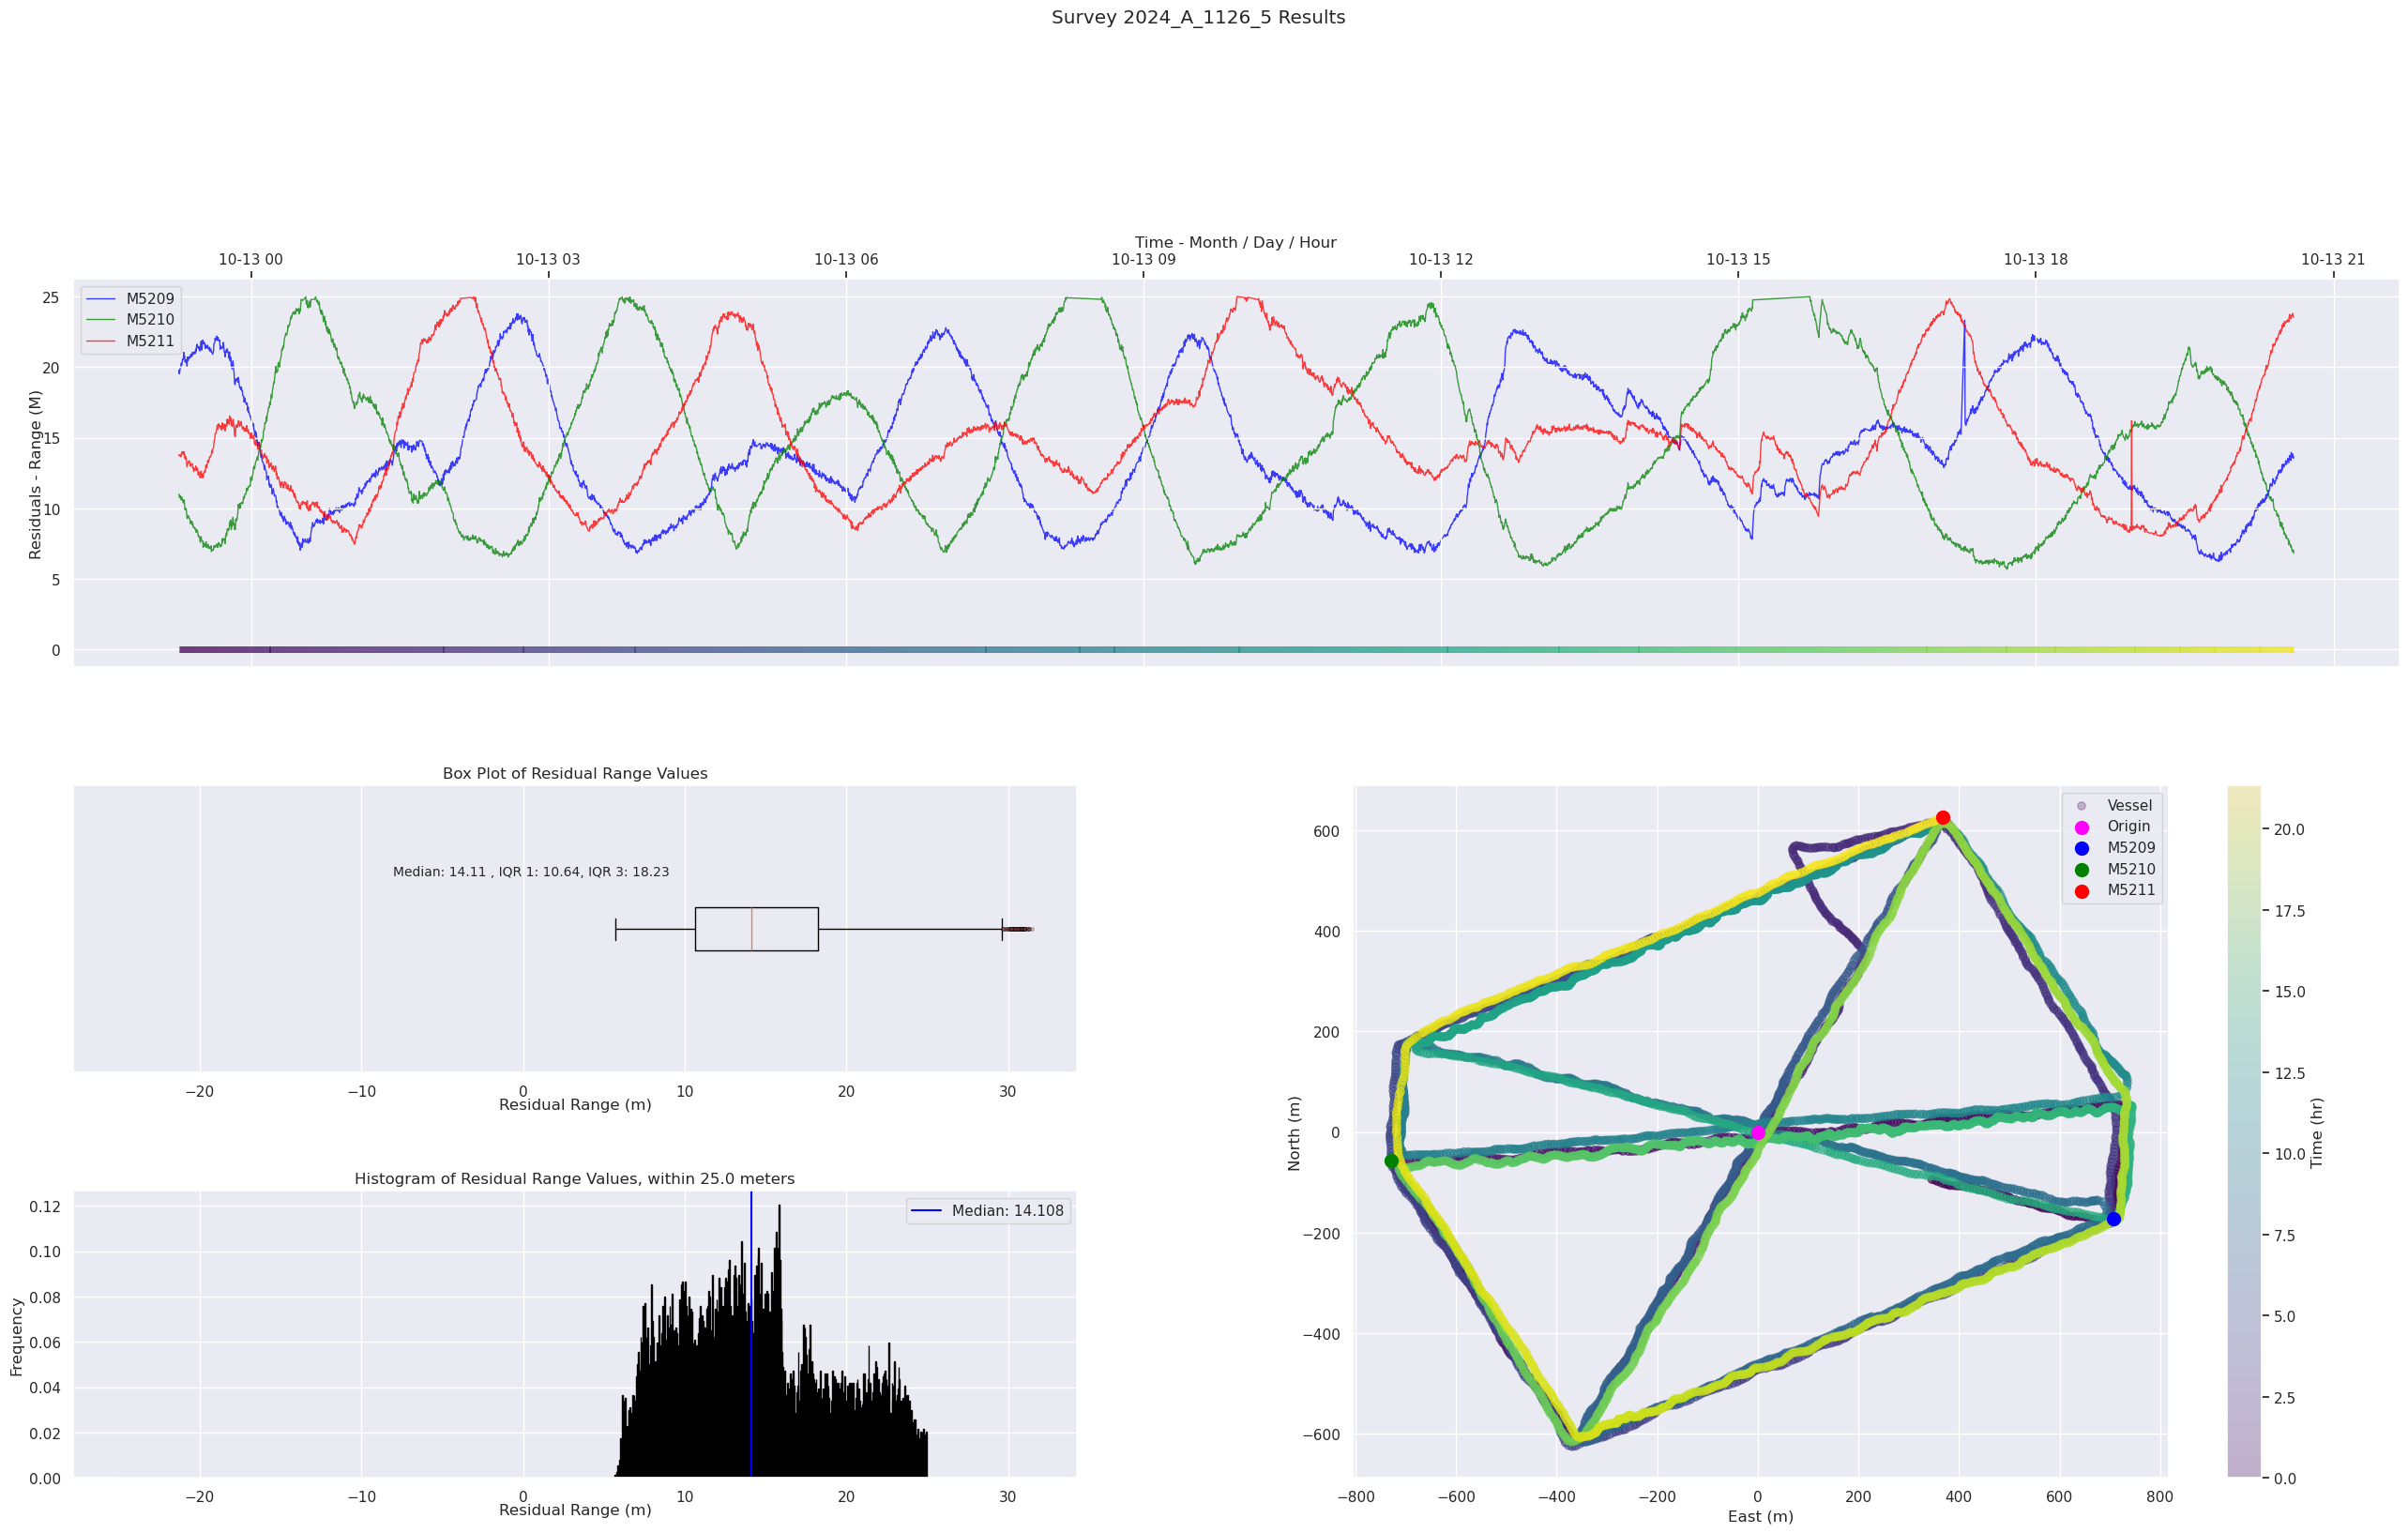

In [12]:
#%matplotlib widget

residual_filter = 25
gp_handler.plot_ts_results(campaign_name=campaign_name,
                           survey_id=survey_id,
                           run_id=0,
                           res_filter=residual_filter)